# CNN for CIFAR-10 Image Classification

In [ ]:
pip install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Define the CNN Architecture

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load and Preprocess CIFAR-10 Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize Some Training Images

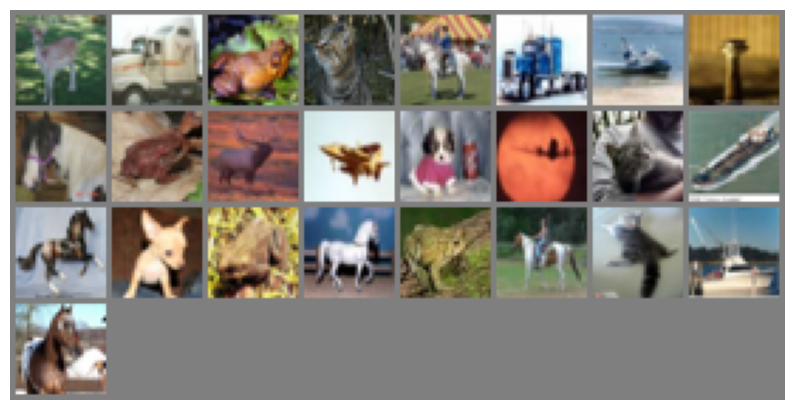

deer  truck frog  cat   horse truck plane bird  horse frog  deer  plane dog   plane cat   ship  horse dog   frog  horse frog  horse cat   ship  horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images[:25]))
plt.show()

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(25)))

## Initialize Model, Loss Function, and Optimizer

In [6]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [7]:
num_epochs = 15
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

Epoch [1/15], Loss: 1.4881, Accuracy: 45.46%
Epoch [2/15], Loss: 1.1103, Accuracy: 60.11%
Epoch [3/15], Loss: 0.9345, Accuracy: 67.10%
Epoch [4/15], Loss: 0.8199, Accuracy: 71.24%
Epoch [5/15], Loss: 0.7339, Accuracy: 74.20%
Epoch [6/15], Loss: 0.6700, Accuracy: 76.26%
Epoch [7/15], Loss: 0.6140, Accuracy: 78.24%
Epoch [8/15], Loss: 0.5621, Accuracy: 79.97%
Epoch [9/15], Loss: 0.5166, Accuracy: 81.49%
Epoch [10/15], Loss: 0.4848, Accuracy: 82.78%
Epoch [11/15], Loss: 0.4433, Accuracy: 84.13%
Epoch [12/15], Loss: 0.4138, Accuracy: 85.02%
Epoch [13/15], Loss: 0.3844, Accuracy: 86.39%
Epoch [14/15], Loss: 0.3631, Accuracy: 86.83%
Epoch [15/15], Loss: 0.3393, Accuracy: 87.78%


## Plot Training Loss and Accuracy

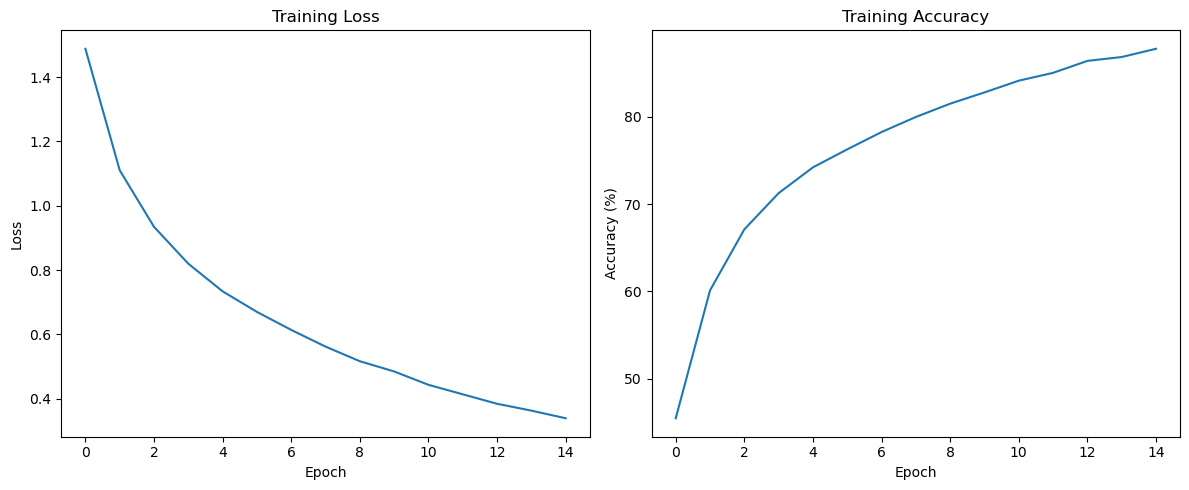

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [ ]:
import random
def show_random_images(model, testloader, classes, num_images=5):
    model.eval()
    dataiter = iter(testloader)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    
    for ax in axes:
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        image = images[0].cpu().numpy().transpose((1, 2, 0))
        image = (image * 0.5 + 0.5).clip(0, 1)  # Unnormalize
        
        ax.imshow(image)
        ax.set_title(f"True: {classes[labels[0]]}\nPred: {classes[predicted[0]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show some random test images with true and predicted labels
print("Sample test images with true and predicted labels:")
show_random_images(model, testloader, classes)

## Save the Model

In [ ]:
torch.save(model.state_dict(), 'cifar10_cnn.pth')
print("Model saved successfully.")